Patrick Gray (patrick.c.gray at duke) - https://github.com/patrickcgray

Chapter 4: Importing and using vector data -- the OGR library
==================================================


## Introduction

The *OGR* library is a companion library to *GDAL* that handles vector data capabilities, including information queryies, file conversions, rasterization of polygon features, polygonization of raster features, and much more. It handles popular formats including the *ESRI Shapefile*, *Keyhole Markup Language*, *PostGIS*, and *SpatiaLite*. For more information on how *OGR* came about and how it relates to *GDAL*, see here: http://trac.osgeo.org/gdal/wiki/FAQGeneral#WhatisthisOGRstuff.

In this tutorial we'll be working with: 
* [Shapely](https://shapely.readthedocs.io/en/stable/manual.html): `shapely` does things like buffers, unions, intersections, centroids, convex hulls, and lots more.
  * `shapely` is a BSD-licensed Python package for manipulation and analysis of planar geometric objects. It is based on the widely deployed GEOS (the engine of PostGIS) and JTS (from which GEOS is ported) libraries. Shapely is not concerned with data formats or coordinate systems, but can be readily integrated with packages that are.
* [Fiona](https://fiona.readthedocs.io/en/latest/): `fiona` does reading and writing data formats.
 * `fiona` is OGR's neat and nimble API for Python programmers. It focuses on reading and writing data in standard Python IO style and relies upon familiar Python types and protocols such as files, dictionaries, mappings, and iterators instead of classes specific to OGR. `fiona` can read and write real-world data using multi-layered GIS formats and zipped virtual file systems and integrates readily with other python GIS packages such as `pyproj`, `Rtree`, and `Shapely`.
* [Descartes](https://bitbucket.org/sgillies/descartes/): a simple library for plotting geometries in `matplotlib`
* [Geopandas](http://geopandas.org/): GeoPandas is an open source project to make working with geospatial data in python easier. 
  * GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.
  * The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS.
* [Folium](https://github.com/python-visualization/folium): builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the leaflet.js library. 
  * Manipulate your data in Python, then visualize it in on a Leaflet map via `folium`. `folium` makes it easy to visualize data that’s been manipulated in Python on an interactive leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing rich vector/raster/HTML visualizations as markers on the map.
  
  
  
Let's explore shapely a bit by creating some shapes:

In [1]:
import shapely
from shapely import geometry
from shapely.geometry import shape, Point, LineString, Polygon

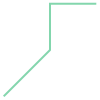

In [2]:
a = LineString([(0, 0), (1, 1), (1,2), (2,2)])
a

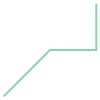

In [3]:
b = LineString([(0, 0), (1, 1), (2,1), (2,2)])
b

With these two lines created we can run some geospatial operations on them like an intersection:

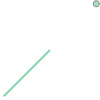

In [4]:
x = b.intersection(a)
x

We can buffer shapes too.

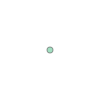

In [5]:
c = Point(1, 1)
c

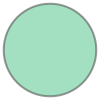

In [6]:
c = c.buffer(1.5)
c

We can do intersections:

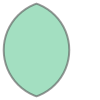

In [7]:
d = Point(2, 1).buffer(1.5)
c.intersection(d)

Or we can do a union instead of an intersection.

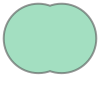

In [8]:
c.union(d)

So far we've just been using the default plotting in Jupyter notebooks. Let's shift now to plotting with matplotlib.

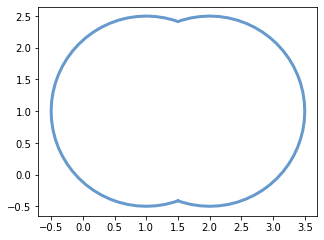

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

BLUE = '#6699cc'
GRAY = '#999999'

fig, ax = plt.subplots(figsize=(5, 5))
x, y = c.union(d).exterior.xy # find all the x and y points in the shape
ax.plot(x, y, color=BLUE, linewidth=3, solid_capstyle='round')
ax.set_aspect('equal') # make the axes equal so the shape isn't distorted
plt.show()

Now let's do something a little more complicated. We're going to plot a line and then buffer around that line in Subplot 1 and then in Subplot 2 we'll plot that buffer and then erode the buffer and plot it on top of the full buffer.

Here we'll use `descartes` to plot these polygon patches in `matplotlib`:

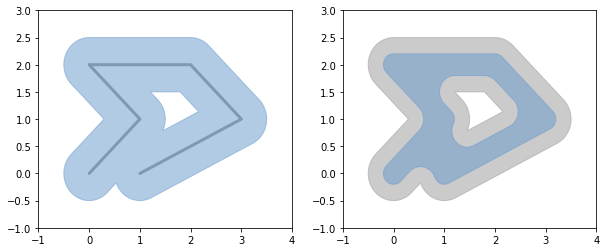

In [10]:
from descartes import PolygonPatch # this is a helpful library for plotting shapely shapes in matplotlib

# let's create a line to plot
line = LineString([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])

fig, axs = plt.subplots(1,2, figsize=(10, 4))

# Subplot # 1
axs[0].set_xlim([-1,4])
axs[0].set_ylim([-1,3])

x, y = line.xy # this gets all the points from the shapely object
axs[0].plot(x, y, color=GRAY, linewidth=3, solid_capstyle='round', zorder=1)

dilated = line.buffer(0.5) # create a dilated version of this line - note this creates a polygon
patch1 = PolygonPatch(dilated, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2) # create a PolygonPatch for easy plotting
axs[0].add_patch(patch1) # add this polygon to the plot

# Subplot # 2
axs[1].set_xlim([-1,4])
axs[1].set_ylim([-1,3])

patch2a = PolygonPatch(dilated, fc=GRAY, ec=GRAY, alpha=0.5, zorder=1)
axs[1].add_patch(patch2a)

eroded = dilated.buffer(-0.3)

# we can use shapely objects but GeoJSON-like data works as well
polygon = eroded.__geo_interface__
patch2b = PolygonPatch(polygon, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2)
axs[1].add_patch(patch2b)

This is of course just a taste. You can do all sorts of cool geometric operations with shapely.

We'll now use an *ESRI Shapefile* that contains training data I collected for the example image we've been working on.

## Opening an *ESRI Shapefile*

Just like *GDAL* in `rasterio`, *OGR* in `fiona` abstracts the file formats so that we can use the same code for any format. It employs the same concept of a *dataset* object which we can gather information from:

### Using fiona to import shapefiles 

In [11]:
import fiona
# Open the dataset from the file
shapefile = fiona.open('../data/rcr/rcr_landcover.shp')
# Make sure the dataset exists -- it would be None if we couldn't open it
if not shapefile:
    print('Error: could not open shapefile')

With our Shapefile read in, we can look at some of its properties:

In [12]:
### Let's get the driver from this file
driver = shapefile.driver
print('Dataset driver is: {n}\n'.format(n=driver))

### How many features are contained in this Shapefile?
feature_count = len(shapefile)
print('The shapefile has {n} feature(s)\n'.format(n=feature_count))

### What is the shapefiles's projection?
# Get the spatial reference
spatial_ref = shapefile.crs
print('The shapefiles spatial ref is:\n', spatial_ref, '\n')

# Let's pull out a specific feature from the shapefile
feature = shapefile[0]

### What is the features's geometry? is it a point? a polyline? a polygon?
geometry = feature['geometry']['type']
print("The features's geometry is: {geom}\n".format(geom=geometry))

### How many properties are in the shapefile, and what are their names?
properties = feature["properties"].keys()

# How many fields
field_count = len(properties)
print('Layer has {n} fields'.format(n=field_count))

# What are their names?
print('Their names are: ')
for prop in properties:
    print('\t{name}'.format(name=prop))

Dataset driver is: ESRI Shapefile

The shapefile has 23 feature(s)

The shapefiles spatial ref is:
 {'init': 'epsg:32618'} 

The features's geometry is: Polygon

Layer has 2 fields
Their names are: 
	Classname
	Classvalue


In [13]:
# you can get a quick view of all of this
shapefile.meta

{'driver': 'ESRI Shapefile',
 'schema': {'properties': OrderedDict([('Classname', 'str:80'),
               ('Classvalue', 'int:18')]),
  'geometry': 'Polygon'},
 'crs': {'init': 'epsg:32618'},
 'crs_wkt': 'PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]'}

The shapefile is a list of features, which can be accessed like any python list

In [14]:
feature = shapefile[0]
feature # The result is a Python dictionary

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('Classname', 'Sand'), ('Classvalue', 2253)]),
 'geometry': {'type': 'Polygon',
  'coordinates': [[(346494.47052450513, 3840484.890103262),
    (346512.1633455531, 3840444.4037230057),
    (346425.2387005355, 3840344.6287597455),
    (346417.20767719497, 3840413.2025623657),
    (346494.47052450513, 3840484.890103262)]]}}

As all dictionaries in Python, there are keys and values.

In [15]:
feature.keys()

dict_keys(['type', 'id', 'properties', 'geometry'])

In [16]:
print('id: ', feature['id']) #gives the id
print('Classname: ', feature['properties']['Classname']) # gives the value of the classname attribute

print('\ngeometry: ', feature['geometry']) # gives the geometry, GeoJSON format

id:  0
Classname:  Sand

geometry:  {'type': 'Polygon', 'coordinates': [[(346494.47052450513, 3840484.890103262), (346512.1633455531, 3840444.4037230057), (346425.2387005355, 3840344.6287597455), (346417.20767719497, 3840413.2025623657), (346494.47052450513, 3840484.890103262)]]}


If you want to transform this geometry into a shapely geometry use the shape function that we imported earlier

<class 'shapely.geometry.polygon.Polygon'>


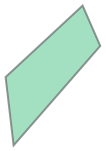

In [17]:
shapely_shape = shape(feature['geometry'])
print(type(shapely_shape))

shapely_shape

We'll come back to this set of training features later!

## Bringing in the real power tools: `geopandas`

Geopandas takes the tools we have seen so far to the next level.

The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS.

From the docs:

    GeoPandas implements two main data structures, a GeoSeries and a GeoDataFrame. These are subclasses of pandas Series and DataFrame, respectively.

    A GeoSeries is essentially a vector where each entry in the vector is a set of shapes corresponding to one observation.

    A GeoDataFrame is a tabular data structure that contains a GeoSeries.

    The most important property of a GeoDataFrame is that it always has one GeoSeries column that holds a special status. This GeoSeries is referred to as the GeoDataFrame‘s “geometry”. When a spatial method is applied to a GeoDataFrame (or a spatial attribute like area is called), this commands will always act on the “geometry” column

Let's show a simple example.

In [18]:
import geopandas as gpd

p1 = Polygon([(0, 0), (1, 0), (1, 1)])
p2 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p3 = Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])
g = gpd.GeoSeries([p1, p2, p3])
print(type(g))
g

<class 'geopandas.geoseries.GeoSeries'>


0         POLYGON ((0 0, 1 0, 1 1, 0 0))
1    POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))
2    POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))
dtype: object

Okay so that is a GeoSeries let's look at a GeoDataFrame using one of the datasets that is packaged with geopandas: a GeoDataFrame of the New York City Boroughs.

In [19]:
nybb_path = gpd.datasets.get_path('nybb')
boros = gpd.read_file(nybb_path)
print(type(boros))
boros

<class 'geopandas.geodataframe.GeoDataFrame'>


,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,4,Queens,896344.047763,3.045213e+09,(POLYGON ((1029606.076599121 156073.8142089844...
2,3,Brooklyn,741080.523166,1.937479e+09,(POLYGON ((1021176.479003906 151374.7969970703...
3,1,Manhattan,359299.096471,6.364715e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464392.991824,1.186925e+09,(POLYGON ((1012821.805786133 229228.2645874023...


Now let's plot that GeoDataFrame

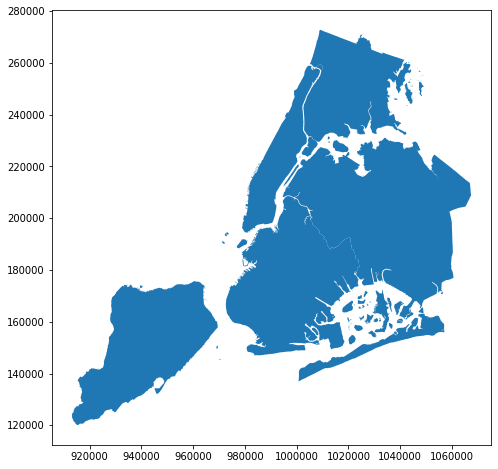

In [20]:
fig, ax = plt.subplots(figsize=(8,8))
boros.plot(ax=ax)

Pretty cool! A plot of the NYC Boroughs just like that!

We can do all the same cool geometric operations to these GeoDataFrames as we could in `shapely`. Here we'll apply [convex hull](https://en.wikipedia.org/wiki/Convex_hull) and color each borough differently.

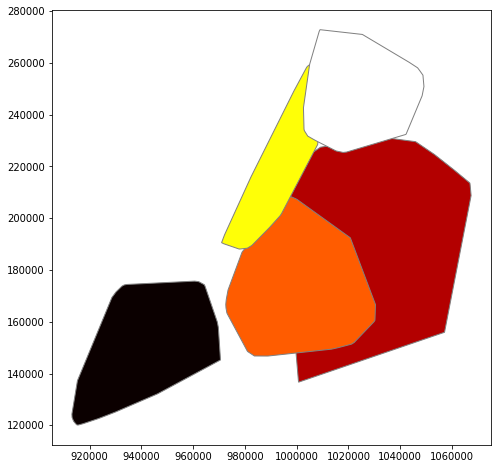

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
boros.geometry.convex_hull.plot(ax=ax, cmap='hot', edgecolor='gray')

Let's look at a dataset with some more attributes. GeoPandas comes pre-packaged with a `world` dataset that'll do.

In [22]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."


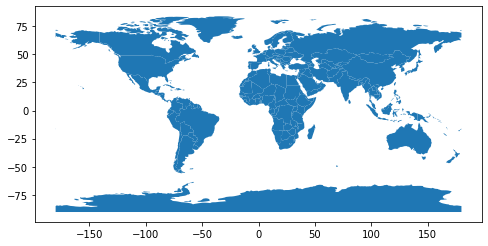

In [23]:
fig, ax = plt.subplots(figsize=(8,8)) 
world.plot(ax=ax)

With geopandas you can do filtering just like in any pandas dataframe

In [24]:
# find all countries with a population greater than 150 million
world[(world.pop_est > 150000000)]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."
8,260580739,Asia,Indonesia,IDN,3028000.0,(POLYGON ((141.0002104025918 -2.60015105551566...
29,207353391,South America,Brazil,BRA,3081000.0,POLYGON ((-53.37366166849824 -33.7683777809007...
56,190632261,Africa,Nigeria,NGA,1089000.0,"POLYGON ((2.691701694356254 6.258817246928629,..."
98,1281935911,Asia,India,IND,8721000.0,"POLYGON ((97.32711388549004 28.26158274994634,..."
99,157826578,Asia,Bangladesh,BGD,628400.0,"POLYGON ((92.67272098182556 22.04123891854125,..."
102,204924861,Asia,Pakistan,PAK,988200.0,"POLYGON ((77.83745079947457 35.49400950778777,..."
139,1379302771,Asia,China,CHN,21140000.0,(POLYGON ((109.4752095886636 18.19770091396857...


We can filter all latitudes greater than 0 leaving only the southern hemisphere

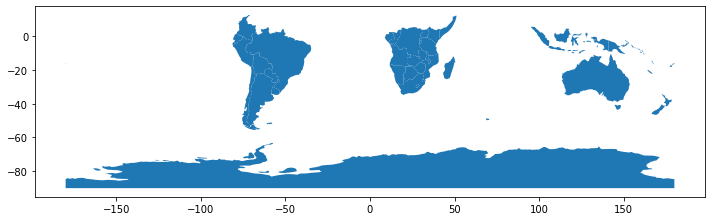

In [25]:
southern_world = world.cx[:, :0]

fig, ax = plt.subplots(figsize=(12,5)) 
southern_world.plot(ax=ax);

We can do more advanced filtering like combining the countries from each continent and then sorting continents by population.

In [26]:
world_filtered = world[['continent', 'geometry', 'pop_est']] # filter to only the columns we care about
continents = world_filtered.dissolve(by='continent', aggfunc='sum') # dissolve countries
continents

,geometry,pop_est
continent,,
Africa,(POLYGON ((49.54351891459575 -12.4698328589405...,1219176238
Antarctica,(POLYGON ((-163.7128956777287 -78.595667413241...,4050
Asia,(POLYGON ((120.2950142762069 -10.2586499976035...,4389144868
Europe,(POLYGON ((-51.65779741067889 4.15623240805302...,746398461
North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1...",573042112
Oceania,(POLYGON ((169.6678145693731 -43.5553256162263...,36782844
Seven seas (open ocean),"POLYGON ((68.935 -48.62500000000001, 69.58 -48...",140
South America,(POLYGON ((-66.95992000000001 -54.896810000000...,418540749


It is also really simple to create Chloropleth maps (maps where the color of each shape is based on the value of an
associated variable). 

Simply use the plot command with the column argument set to the column whose values you want used to assign colors.

Let's calculate and plot by GDP per capita

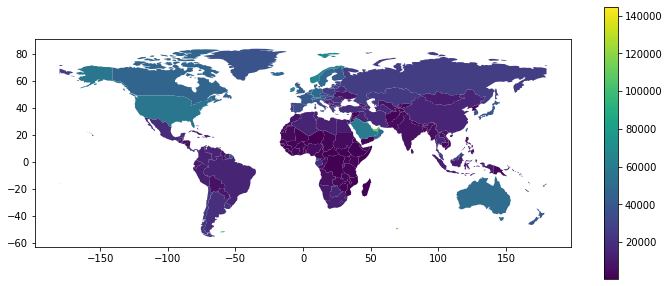

In [27]:
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['gdp_per_cap'] = world.gdp_md_est / world.pop_est
world['gdp_per_cap'] = world['gdp_per_cap'] * 1000000 # because it was calcualted in millionths

fig, ax = plt.subplots(figsize=(12,5))
world.plot(column='gdp_per_cap', legend=True, ax=ax) # let's also add a colorbar

Let's take a look at some ocean and glacier data

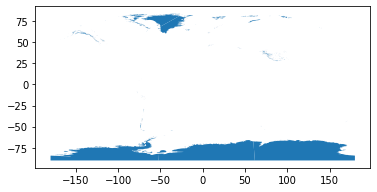

In [28]:
# load in the data
# data available from http://www.naturalearthdata.com/downloads/
glaciers = gpd.read_file("../data/shapefiles/ne_10m_glaciated_areas.shp")
glaciers.plot()

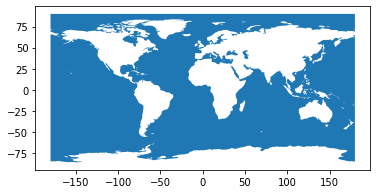

In [29]:
# data available from http://www.naturalearthdata.com/downloads/
oceans = gpd.read_file("../data/shapefiles/ne_110m_ocean.shp")
oceans.plot()

Let's overlay the oceans, countries, and glaciers

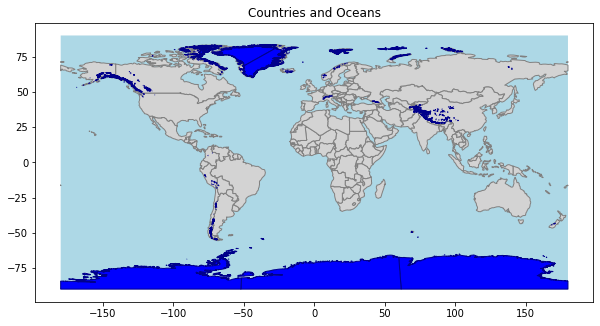

In [30]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.set_title('Countries and Oceans')
oceans.plot(ax=ax, facecolor='lightblue')
world.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
glaciers.plot(ax=ax, facecolor='blue', edgecolor='darkblue')
ax.set_aspect('equal')

Let's look at Anchorage Alaska at 61.2181° N, 149.9003° W

Note there are some mismatches between the glacier and land datasets because of the different resolutions

(-155, -145)

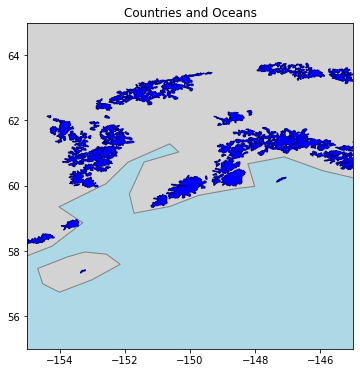

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Countries and Oceans')
oceans.plot(ax=ax, facecolor='lightblue')
world.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
glaciers.plot(ax=ax, facecolor='blue', edgecolor='darkblue')

# specify a location by lat and long
ax.set_ylim([55, 65])
ax.set_xlim([-155, -145])

# Now let's combine this new vector knowledge with our raster dataset

### For now, let's visualize our raster and shapefile datasets together

In [32]:
import rasterio
import numpy as np
dataset = rasterio.open('../data/sentinel-2/2018-10-13, Sentinel-2B L1C, B08.tiff')

Read our shapefile straight into a geopandas GeoDataFrame

In [33]:
shapefile = gpd.read_file('../data/rcr/rcr_landcover.shp')
shapefile.head()

,Classname,Classvalue,geometry
0,Sand,2253,"POLYGON ((346494.4705245051 3840484.890103262,..."
1,Forested Wetland,2360,"POLYGON ((347156.6195963654 3842382.622676761,..."
2,Forested Wetland,2360,"POLYGON ((347374.2493280142 3842272.855209821,..."
3,Sand,2253,"POLYGON ((347752.9399173185 3842285.305343091,..."
4,Emergent Wetland,2260,"POLYGON ((352462.7065634858 3840569.388199177,..."


We could filter the DF down to the columns we care about if we wanted to:

In [34]:
shapefile_filtered = shapefile.filter(['Classname', 'geometry'])
shapefile_filtered.head()

,Classname,geometry
0,Sand,"POLYGON ((346494.4705245051 3840484.890103262,..."
1,Forested Wetland,"POLYGON ((347156.6195963654 3842382.622676761,..."
2,Forested Wetland,"POLYGON ((347374.2493280142 3842272.855209821,..."
3,Sand,"POLYGON ((347752.9399173185 3842285.305343091,..."
4,Emergent Wetland,"POLYGON ((352462.7065634858 3840569.388199177,..."


#### Okay now let's try to find the bounding box of the raster and visualize it

These look like lat lon coordinates but let's make sure:

In [35]:
dataset.crs

CRS.from_epsg(4326)

Not very human readable... let's use pyproj to make sure:

In [36]:
from pyproj import CRS

CRS(dataset.crs)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now let's check our shapefile crs:

In [37]:
shapefile.crs

{'init': 'epsg:32618'}

In [38]:
CRS(shapefile.crs)

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 78°W to 72°W - by country
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

They are different! 

We could project the shapefile to lat long or we could change the raster to `epsg:32618` which is UTM 18N. For now since, we are only worried about the raster bounds, we'll change the crs of those four points to UTM 18N.

Let's find all four corner points by using `dataset.transform * (<pixel location>)` which allows you to input a pixel location and returns a coordinate pair in the current CRS:

In [39]:
from pyproj import transform
from pyproj import Proj
# this will get our four corner points
raster_gps_points = dataset.transform * (0, 0), dataset.transform * (dataset.width, 0), dataset.transform * (dataset.width, dataset.height), dataset.transform * (0, dataset.height),

# Project all longitudes, latitudes using the pyproj package
p1 = Proj(dataset.crs) # our current crs
p2 = Proj(shapefile.crs) # the crs we want our raster to be in
# we could also specifc UTM 18N as:
#   p2 = Proj("+proj=utm +zone=18, +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

# use the pyproj.transform function to convert the positions to longs, lats
UTMx, UTMy = transform(p1, p2, np.array(raster_gps_points)[:,1],np.array(raster_gps_points)[:,0])

raster_utm_points = list(zip(UTMx, UTMy)) # zip up the points so they're in the form [(lat, long), ...]

print('raster bounds in UTM 18N:\n', raster_utm_points, '\n')
print('raster bounds in lat, lon:\n', raster_gps_points)

raster bounds in UTM 18N:
 [(342874.29359233467, 3844458.611782608), (364501.9870325172, 3844114.8502116846), (364236.96553226013, 3826072.8217074675), (342566.9381240971, 3826415.843995134)] 

raster bounds in lat, lon:
 ((-76.716188, 34.730144), (-76.479982, 34.730144), (-76.479982, 34.567461), (-76.716188, 34.567461))


Great now we've got our raster bounds and shapefile in matching coordinate reference systems!

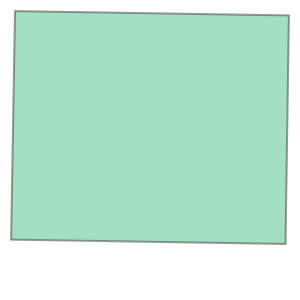

In [40]:
# we can make a simple Shapely shape out of these bounds if we want
raster_geometry = {
    'type' : 'Polygon',
    'coordinates' : [list(raster_utm_points)]     
         }
raster_shape = shape(raster_geometry)
raster_shape

### let's overlay our raster bounds and shapefile features

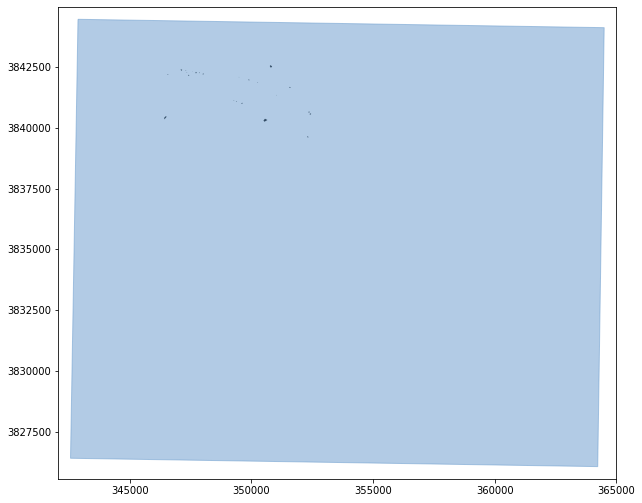

In [41]:
from descartes import PolygonPatch # this package helps us plot polygons and is used internally by GeoPandas to plot
import matplotlib.pyplot as plt

BLUE = '#6699cc'
GRAY = '#000000'

fig, ax = plt.subplots(figsize=(10,10))

# add raster bounds
poly1patch = PolygonPatch(raster_shape, fc=BLUE, ec=BLUE, alpha=0.5)
ax.add_patch(poly1patch)

# While we could do something like this:
#     for feat in shapefile:
#         ax.add_patch(PolygonPatch(shape(feat['geometry']), fc=GRAY, ec=GRAY, alpha=0.5, zorder=2))

# Geopandas implements this internally so all we need to do is:

shapefile.plot(ax=ax, color='black')

xrange = [int(min(raster_shape.exterior.xy[0]))-500, int(max(raster_shape.exterior.xy[0]))+500]
yrange = [int(min(raster_shape.exterior.xy[1]))-500, int(max(raster_shape.exterior.xy[1]))+500]

ax.set_xlim(*xrange)
ax.set_ylim(*yrange)
ax.set_aspect('equal')
plt.show()

### hmm challenging to see, let's zoom in a bit

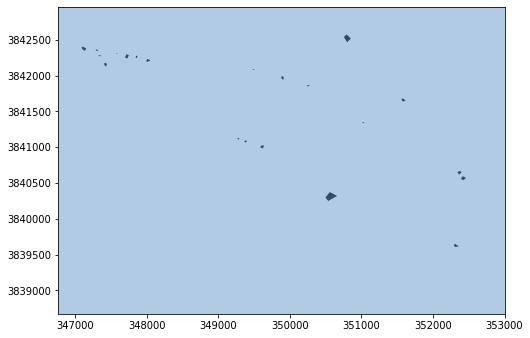

In [42]:
fig, ax = plt.subplots(figsize=(8,8))

# add raster bounds
poly1patch = PolygonPatch(raster_shape, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2)
ax.add_patch(poly1patch)

shapefile.plot(ax=ax, color='black')

xrange = [int(min(raster_shape.exterior.xy[0]))+4200, int(max(raster_shape.exterior.xy[0]))-11500]
yrange = [int(min(raster_shape.exterior.xy[1]))+12600, int(max(raster_shape.exterior.xy[1]))-1500]
ax.set_xlim(*xrange)
ax.set_ylim(*yrange)
ax.set_aspect('equal')
plt.show()

### still not extremely useful, let's make it interactive and add some class labels

In [43]:
import folium # let's make an interactive map using leaflet

# folium requires lat, long but dataset.transform outputs long, lat so reversing them:
raster_gps_reversed = list(zip(np.array(raster_gps_points)[:,1], np.array(raster_gps_points)[:,0]))

# creating these points just to set the map center
lat, long = raster_gps_reversed[1] 

# create the folium map object
m = folium.Map(location=[lat, long], zoom_start=11) # set the map centered around the first point

# this actually adds the polygon to the map
folium.Polygon(raster_gps_reversed, 
               popup='Sentinel-2 Image Bounds',
               color='#3186cc',
               fill=True,
               fill_color='#3186cc'
              ).add_to(m)

# there may be a more efficient way to add these, need to check recent folium updates
for index in range(0, len(shapefile)):
    # pick out each feature by its index
    feat = shapefile.iloc[index]
    feat_geom = shape(feat['geometry'])
    feat_name = feat['Classname']
    
    # have to do error catching because .exterior.xy doesn't work for multipart polygons
    try:
        # again use Pyproj to reproject the crs now in the opposite direction
        p1 = Proj(shapefile.crs)
        p2 = Proj(dataset.crs) # we want to display on folium using WGS84
        # we could also do
        #    p2 = Proj(proj='latlong',datum='WGS84') # we want to display on folium using WGS84
        lats, longs = transform(p1, p2, feat_geom.exterior.xy[0], feat_geom.exterior.xy[1])
        gps_points = list(zip(lats, longs)) # zip up the points so they're in the form [(lat, long), ...]

        folium.Polygon(gps_points, 
                   tooltip=feat_name, 
                   color='#000000',
                   fill=True,
                   fill_color='#99999'
                      ).add_to(m)
    except AttributeError:
        pass

m

### Now that is actually useful for exploring the dataset!

## Wrapup

Now that we have all these tools in our toolkit, we can proceed to use them for pairing our labeled polygons with the matching pixels in our Planet image to train a classifier for image classification. We continue this step in the next chapter (link to [webpage](chapter_5_classification.html) or [Notebook](chapter_5_classification.ipynb)).

For more visualization goodies I strongly suggest checking out some of the following:
- `Geoplot`
  - Docs here: https://residentmario.github.io/geoplot/index.html  
  - Integration with `Geopandas` here: http://geopandas.org/gallery/plotting_with_geoplot.html#sphx-glr-gallery-plotting-with-geoplot-py
  
---

## BONUS KNOWLEDGE!!!

## Read from OGC WFS GeoJSON response into a GeoDataFrame

- This example drawn from https://geohackweek.github.io/vector/04-geopandas-intro/

#### Don't worry too much about the specifics here, this is an example just to show the power of these common formats for sharing data and getting really informative datasets from all sorts of databases

Use an Open Geospatial Consortium (OGC) Web Feature Service (WFS) request to obtain geospatial data from a remote source. OGC WFS is an open geospatial standard.

We won’t go into all details about what’s going on. Suffice it to say that we issue an OGC WFS request for all features from the layer named “oa:goainv” found in a GeoServer instance from NANOOS, requesting the response in GeoJSON format. Then we use the geojson package to “load” the raw response (a GeoJSON string) into a geojson feature object (a dictionary-like object).

The “oa:goainv” layer is a global dataset of monitoring sites and cruises where data relevant to ocean acidification are collected. It’s a work in progress from the Global Ocean Acidification Observation Network (GOA-ON); for additional information see the GOA-ON Data Portal.

In [44]:
import requests
import geojson

# set up request parameters
wfs_url = "http://data.nanoos.org/geoserver/ows"
params = dict(service='WFS', version='1.0.0', request='GetFeature',
              typeName='oa:goaoninv', outputFormat='json')

# make the request
r = requests.get(wfs_url, params=params)
wfs_geo = geojson.loads(r.content)

Let’s examine the general characteristics of this GeoJSON object, including its __geo_interface__ interface, which we discussed earlier.

In [45]:
print(type(wfs_geo))
print(wfs_geo.keys())
print(len(wfs_geo.__geo_interface__['features']))

<class 'geojson.feature.FeatureCollection'>
dict_keys(['type', 'totalFeatures', 'crs', 'features'])
598


Now use the from_features constructor method to create a GeoDataFrame directly from the geojson.feature.FeatureCollection object.

In [46]:
wfs_gdf = gpd.GeoDataFrame.from_features(wfs_geo)

Finally, let’s visualize the data set as a simple map overlay plot; and as an example, display the values for the last feature.

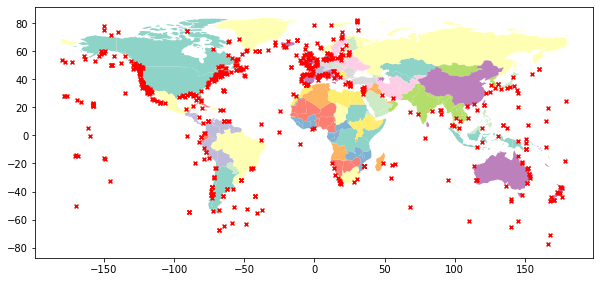

In [47]:
wfs_gdf.plot(ax=world.plot(cmap='Set3', figsize=(10, 6)),
             marker='x', markersize=15,  color='red');

What kind of data is contained in each of these points? Well let's take a glimpse:

In [48]:
wfs_gdf.iloc[0]

Oceans                                                    North Atlantic Ocean
SDG                                                                        YES
additional_organizations                                                      
agency                                      Israeli Ministry of Infrastructure
city                                                                     Haifa
comments                                                                      
comments_about_overlaps                                                       
contact_email                                             jacobs1@ocean.org.il
contact_name                                                   Jacob Silverman
country                                                                 Israel
data_quality                                                           climate
data_url                                                                      
department                                          